# Réseau fully connected

## Architecture

Dans les cours précédents ([cours 2](../02_RéseauFullyConnected/README.md)), nous avons construits des réseaux de neurones fully connected pour des problèmes de classification. Ici, nous avons à faire à un problème de prédiction et nos données sont discrètes.  

### Inspiration

Le réseau construit dans ce notebook est basé sur l'article ["A Neural Probabilistic Language Model"](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf).  

Voici à quoi ressemble l'architecture de ce réseau :  

![Bengio](./images/bengio.png)

Figure extraite de l'article original.


Dans l'article, le modèle utilise des mots en entrée (3 mots dans l'exemple illustré) pour prédire le mot suivant. Dans notre cas, nous allons utiliser des caractères, comme nous l'avons fait dans le notebook précédent. 

**Matrice d'embedding $C$** : À première vue, on remarque que le réseau comporte une matrice $C$ qui va encoder le mot (ou le caractère) dans un espace latent. C'est une pratique presque systématiquement utilisé en NLP car cela permet de rapprocher les mots "similaires" dans un espace latent.  
Par exemple, dans la plupart des phrases on pourrait interchanger les mots "chien" et "chat", ce qui signifie que ces mots vont avoir une representation proche dans l'espace latent tandis que les mots "chien" et "est" ne vont pas avoir une representation proche.   

**Reste du réseau** : Le reste du réseau est plus classique, il prend en entrée la concatenation des embeddings des différents mots (ou caractères) et prédit un mot (ou caractère en sortie).

Le modèle de l'article est entraîné par minimisation du *negative log likelihood* (comme ce que nous avons fait dans le notebook précédent avec le modèle bigramme).

### Notre approche

Dans l'article, ils utilisent 3 mots pour prédire le 4ème mot. Nous allons nous baser sur le même principe et prédire le 4ème caractère à partir des 3 caractères précédents.  
La dimension de l'espace latent utilisé dans l'article est 30 pour un dictionnaire contenant 17 000 mots distincts. Comme nous avons 46 caracactères, prenons une dimension d'embedding de 10 assez arbitrairement.

## Implémentation 

Commençons par reconstruire nos listes stoi et itos du [notebook précédent](../05_NLP/02_bigramme.ipynb) : 

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, random_split
%matplotlib inline

In [2]:
words = open('prenoms.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

### Dataset et dataloader

Construisons notre dataset, qui sera légèrement différent, car les entrées seront au nombre de trois au lieu d'une.

In [3]:
block_size = 3 # La longueur du contexte, combien de caractères pour prédire le suivant ?
X, Y = [], []
for k,w in enumerate(words):
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    if (k<2): ## On affiche ce à quoi ressemble le dataset pour les deux premiers mots
      print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

... ---> M
..M ---> A
.MA ---> R
MAR ---> I
ARI ---> E
RIE ---> .
... ---> J
..J ---> E
.JE ---> A
JEA ---> N
EAN ---> .


In [4]:
X = torch.tensor(X)
Y = torch.tensor(Y)
print(X.shape, X.dtype, Y.shape, Y.dtype)

torch.Size([226325, 3]) torch.int64 torch.Size([226325]) torch.int64


On va maintenant utiliser pytorch pour construire nos dataset de training, validation et test.

In [5]:
dataset=TensorDataset(X, Y)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(TensorDataset(X, Y),[train_size, val_size, test_size])
print("Taille du dataset de training : ",len(train_dataset))
print("Taille du dataset de validation : ",len(val_dataset))
print("Taille du dataset de test : ",len(test_dataset))

Taille du dataset de training :  181060
Taille du dataset de validation :  22632
Taille du dataset de test :  22633


Et on va créer nos dataloaders pour l'optimisation par *mini-batch*.

In [6]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

### Couches du réseau 

Pour comprendre en profondeur le réseau que l'on construit ici, nous n'utiliserons pas les fonctions nn.Linear() de pytorch pour la construction des couches.   
On va commencer par définir le nombre de neurones des différentes couches.

In [7]:
embed_dim=10 # Dimension de l'embedding de C
hidden_dim=200 # Dimension de la couche cachée

Construisons notre matrice $C$ d'embedding (qui a des paramètres apprenables).

In [8]:
C = torch.randn((46, embed_dim))
C[X].shape

torch.Size([226325, 3, 10])

En appelant C[X], grâce au formidable [indexing de pytorch](http://blog.ezyang.com/2019/05/pytorch-internals/). On obtient les valeurs d'embedding de chacun des 3 caractères de nos 226325 exemples.

On peut maintenant créer nos couches cachées $W_1$ et $W_2$ ainsi que leurs biais $b_1$ et $b_2$.

In [9]:
W1 = torch.randn((block_size*embed_dim, hidden_dim))
b1 = torch.randn(hidden_dim)
W2 = torch.randn((hidden_dim, 46))
b2 = torch.randn(46)
parameters = [C, W1, b1, W2, b2]
print("Nombre de paramètres du modèle : ",sum(p.nelement() for p in parameters))

Nombre de paramètres du modèle :  15906


Pour pouvoir entraîner ces couches, il faut activer le paramètre *requires_grad* de pytorch. Cela permet de spécifier que l'on souhaite calculer les gradients sur ces éléments.

In [10]:
for p in parameters:
  p.requires_grad = True

### Comment trouver le bon learning rate ?

Le choix du *learning rate* est très important lors de l'entraînement d'un réseau de neurones et il est souvent difficile de savoir quelle valeur choisir avant d'avoir fait des tests.   
Une bonne façon de choisir le *learning rate* est la suivante :   
On construit une liste de 1000 valeurs entre -3 et 0 puis on prend $10^{valeur}$ pour chaque valeur
Cela va nous donner une liste de valeurs entre $10^{-3} = 0.001$ et $10^{0}=1$ qui sont un panel de valeurs potentielles pour notre *learning rate*. Les valeurs -3 et 0 peuvent être différentes, vous devez essayer de trouver des valeurs encadrant le *learning rate* optimal.

In [11]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

On va ensuite tracker les valeurs de *loss* en fonction du *learning rate* sur l'ensemble de nos valeurs sur l'entraînement.

In [12]:
lri = []
lossi = []
count=0
while count<999:
  for x,y in train_loader:
    count+=1
    if count==999:
        break
    # forward pass
    emb = C[x]
    h = torch.tanh(emb.view(-1, block_size*embed_dim) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, y)
    
    # retropropagation
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Mise à jour des poids du modèle
    lr = lrs[count]
    for p in parameters:
        p.data += -lr * p.grad

    lri.append(lre[count])
    lossi.append(loss.log10().item())

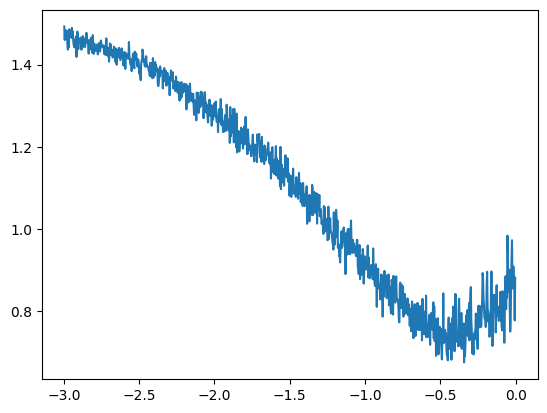

In [13]:
plt.plot(lri, lossi)

Avec cette courbe, on peut déduire qu'une bonne valeur de *learning rate* se situe aux alentours de $10^{-1}$ et $10^{-0.5}$.  
On va donc choisir un *learning rate* de 0.2 que l'on diminuera au cours de l'entraînement (pratique courante pour une convergence rapide et un optimisation précise sur la fin de l'entraînement).

### Point sur la tangente hyperbolique

Dans notre optimisation, nous avons utilisé la fonction tangente hyperbolique comme fonction d'activation.   
Elle est définie de la manière suivante :   
$\tanh(x) = \frac{\sinh(x)}{\cosh(x)} = \frac{e^x - e^{-x}}{e^x + e^{-x}}$  
Et on peut la visualiser en python : 

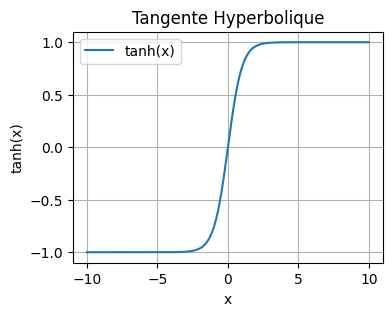

In [14]:
import numpy as np
x = np.linspace(-10, 10, 400)

y = np.tanh(x)

plt.figure(figsize=(4, 3))
plt.plot(x, y, label='tanh(x)')
plt.title('Tangente Hyperbolique')
plt.xlabel('x')
plt.ylabel('tanh(x)')
plt.grid(True)
plt.legend()
plt.show()

En général, dans les couches cachées de notre réseau, on privilegie l'utilisaton de *tanh* plutôt que *sigmoid* et cela pour plusieurs raisons : 
- La plage de sortie centrée sur zéro (-1 à 1) facilite l'apprentissage.
- Les gradients sont plus importants pour des valeurs entre -2 et 2 que pour la fonction sigmoïde
- Les deux élements précédents conduisent à une diminution du problème de [vanishing gradient](https://medium.com/@amanatulla1606/vanishing-gradient-problem-in-deep-learning-understanding-intuition-and-solutions-da90ef4ecb54) et permettent une convergence plus rapide lors de l'entraînement. 

### Optimisation du réseau 

Passons maintenant à l'optimisation de notre réseau. Définissons nos hyperparamètres : 

In [15]:
lr=0.2
epochs=100

# Reinitialisons les paramètres pour plus de simplicité si on a besoin de relancer l'entraînement
C = torch.randn((46, embed_dim))
W1 = torch.randn((block_size*embed_dim, hidden_dim))
b1 = torch.randn(hidden_dim)
W2 = torch.randn((hidden_dim, 46))
b2 = torch.randn(46)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True


In [16]:
lossi=[]
lossvali=[]
stepi = []
for epoch in range(epochs):
  loss_epoch=0
  for x,y in train_loader:
    
    # forward pass
    emb = C[x]
    h = torch.tanh(emb.view(-1, block_size*embed_dim) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, y)
    
    # retropropagation
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Mise à jour des poids du modèle
    lr=lr if epoch<50 else lr*0.1
    for p in parameters:
        p.data += -lr * p.grad
    loss_epoch+=loss

  loss_epoch=loss_epoch/len(train_loader)
  stepi.append(epoch)
  lossi.append(loss_epoch.item())
  # Calcul du loss de validation (pour surveiller l'overfitting)
  loss_val=0
  for x,y in val_loader:
    emb = C[x]
    h = torch.tanh(emb.view(-1, block_size*embed_dim) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, y)
    loss_val+=loss
  loss_val=loss_val/len(val_loader)
  lossvali.append(loss_val.item())
  if epoch%10==0:
    print(f"Epoch {epoch} - Training loss: {loss_epoch.item():.3f}, Validation loss: {loss_val.item():.3f}")

Epoch 0 - Training loss: 5.273, Validation loss: 3.519
Epoch 10 - Training loss: 2.424, Validation loss: 2.594
Epoch 20 - Training loss: 2.337, Validation loss: 2.421
Epoch 30 - Training loss: 2.289, Validation loss: 2.468
Epoch 40 - Training loss: 2.259, Validation loss: 2.424
Epoch 50 - Training loss: 2.327, Validation loss: 2.372
Epoch 60 - Training loss: 2.326, Validation loss: 2.372
Epoch 70 - Training loss: 2.326, Validation loss: 2.372
Epoch 80 - Training loss: 2.326, Validation loss: 2.372
Epoch 90 - Training loss: 2.326, Validation loss: 2.372


Traçons les courbes de training et de validation.

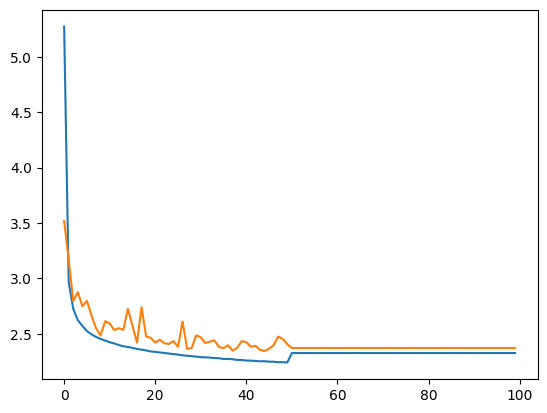

In [17]:
plt.plot(stepi, lossi)
plt.plot(stepi,lossvali)

### Test du modèle

Maintenant que le modèle est entraîné, on va vérifier ses performances sur les données de test. Si le *loss* sur les données de test est à peu près similaire au *loss* d'entraînement alors le modèle est bien entraîné. Dans le cas contraire, il peut s'agir d'*overfitting*. 

In [18]:
# On annule le calcul des gradients car on n'est plus en phase d'entraînement.
for p in parameters:
  p.requires_grad = False
loss_test=0
for x,y in test_loader:
      
  # forward pass
  emb = C[x]
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
  logits = h @ W2 + b2 
  loss = F.cross_entropy(logits, y)

  loss_test+=loss
loss_test=loss_test/len(test_loader)
print(loss_test)

tensor(2.3505)


On a un *likelihood* sur les données de test relativement proche de celui des données d'entraînement, on peut donc conclure que l'entraînement s'est plutôt bien passé.

On peut remarquer que la valeur du *negative log likelihood* sur notre modèle est inférieure à celle du modèle bigramme du notebook précédent ($2.3<2.5$). La qualité des prénoms générés devrait donc être améliorée.

### Géneration de prénoms avec notre modèle

Générons une vingtaine de prénoms pour juger nous-même de la qualité de la génération.

In [19]:
for _ in range(20):
  out = []
  context = [0] * block_size 
  while True:
    emb = C[torch.tensor([context])] 
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  
  print(''.join(itos[i] for i in out))

JAÏMANT.
SONELIUWAN.
LYPHELSÏL.
DJELINATHEYMONDALYANE.
ERNANDRAN.
ESMALLOONIS.
ASHAMLANCHOND.
ANNAE.
CHALLA.
ETTE.
ASSANE.
MARIANE.
FIHAYLAY.
SHANA.
ALPHENELIESON.
ESÏL.
EVEY.
YSLALLYSSIA.
ETHELDOF.
KELLAH.


Les prénoms générés sont certes encore étranges, mais ils ressemblent déjà beaucoup plus à des prénoms "possibles" comparés à ceux produits par le modèle bigramme. 

**Exercice** : Vous pouvez essayer de modifier les neurones des couches ou les hyperparamètres pour améliorer le modèle et constater la différence dans la qualité de génération. 

## Visualisation des embeddings

Plus tôt dans le notebook, nous avons expliqué l'intuition derrière la matrice d'*embedding* $C$ qui sert à "rapprocher" les mots (ou caractères) ayant un sens proche. On ne peut pas facilement visualiser la positions de chaque caractère dans la matrice $C$. Pour avoir une visualisation, on va donc ré-entraîner un modèle mais avec une dimension d'*embedding* de 2 au lieu de 10. Cela nous permettra de visualiser la matrice $C$. 

**Note** : Pour visualiser les embeddings de dimension supérieure à 2 en 2D, on peut utiliser la méthode [T-SNE ou UMAP](https://arize.com/blog-course/reduction-of-dimensionality-top-techniques/).

In [23]:
lr=0.2
epochs=100

C = torch.randn((46, 2)) # 2 au lieu de embed_dim
W1 = torch.randn((block_size*2, hidden_dim))
b1 = torch.randn(hidden_dim)
W2 = torch.randn((hidden_dim, 46))
b2 = torch.randn(46)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

In [24]:
lossi=[]
stepi = []
for epoch in range(epochs):
  loss_epoch=0
  for x,y in train_loader:
    # forward pass
    emb = C[x]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #6 au lieu de 30
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, y)
    # retropropagation
    for p in parameters:
        p.grad = None
    loss.backward()
    # Mise à jour des poids du modèle
    lr=lr if epoch<50 else lr*0.1
    for p in parameters:
        p.data += -lr * p.grad
    loss_epoch+=loss
  loss_epoch=loss_epoch/len(train_loader)
  stepi.append(epoch)
  lossi.append(loss_epoch.item())
  
  # Validation
  loss_val=0
  for x,y in val_loader:
    emb = C[x]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #6 au lieu de 30
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, y)
    loss_val+=loss
  loss_val=loss_val/len(val_loader)
  lossvali.append(loss_val.item())
  if epoch%10==0:
    print(f"Epoch {epoch} - Training loss: {loss_epoch.item():.3f}, Validation loss: {loss_val.item():.3f}")

Epoch 0 - Training loss: 3.822, Validation loss: 3.294
Epoch 10 - Training loss: 2.490, Validation loss: 2.616
Epoch 20 - Training loss: 2.425, Validation loss: 2.532
Epoch 30 - Training loss: 2.388, Validation loss: 2.498
Epoch 40 - Training loss: 2.365, Validation loss: 2.529
Epoch 50 - Training loss: 2.386, Validation loss: 2.399
Epoch 60 - Training loss: 2.385, Validation loss: 2.399
Epoch 70 - Training loss: 2.386, Validation loss: 2.399
Epoch 80 - Training loss: 2.385, Validation loss: 2.399
Epoch 90 - Training loss: 2.385, Validation loss: 2.399


Comme vous le voyez, le *loss* est plus important car une dimension d'*embedding* de 2 est insuffisante pour correctement representer chaque caractère.  
Par contre, on peut maintenant visualiser la position des mots dans l'espace latent. 

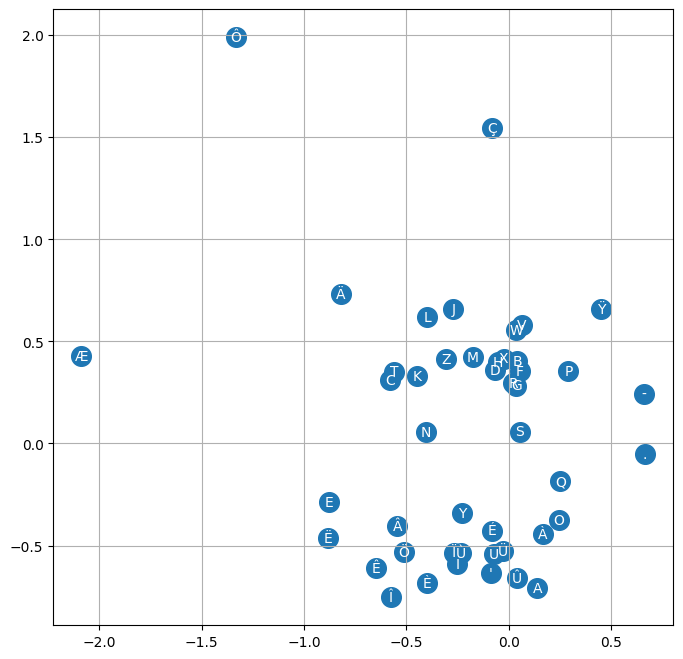

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

On peut voir une tendance avec un regroupement des voyelles et un regroupement des consonnes (qui sont souvent interchangeables dans un prénom). Les caractères très rares ont des embeddings vraiment à part ('ç', 'ö', 'ë'). On peut également remarquer la proximité entre '.' et '-' ce qui est très logique quand on pense à ce qu'est un prénom composé dans la langue française.   
Cela montre que la matrice $C$ a appris une sorte de *mapping* des caractères en fonction de leur proximité sémantique.